In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
numParImpar = str(10)
numSW = str(9)
tempoExp = 351

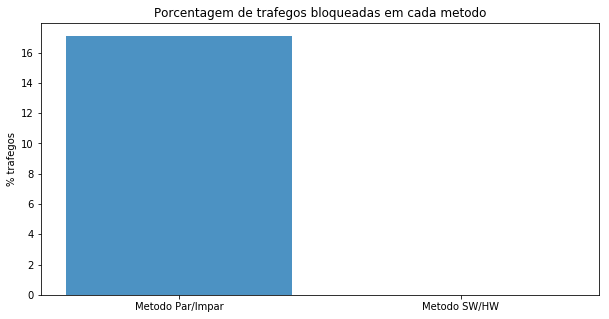

In [3]:
#Pegando informacoes para grafico de bloqueados
dfInfoParImpar = pd.read_csv("../Saidas/Teste"+numParImpar+"/info_parimpar.txt", sep=" ")
dfInfoSWHW = pd.read_csv("../Saidas/Teste"+numSW+"/info_sw.txt", sep=" ")

#Divide por 2 porque é a quantidade de trafegos bloqueados, nao regras
taxaBloqueioPI = (dfInfoParImpar['RegrasBloqueadas'].max()/2/float(1000))*100
taxaBloqueioSW = (dfInfoSWHW['VezesBloqueado'].max()/2/float(1000))*100

colunas = ('Metodo Par/Impar', 'Metodo SW/HW')
posicao = np.arange(len(colunas))
barras = [taxaBloqueioPI, taxaBloqueioSW]

plt.bar(posicao, barras, align='center', alpha=0.8)
plt.xticks(posicao, colunas)
plt.ylabel('% trafegos')
plt.title('Porcentagem de trafegos bloqueadas em cada metodo')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.savefig('trafegosBloqueados_teste'+numParImpar+'e'+numSW+'.pdf')
plt.show()

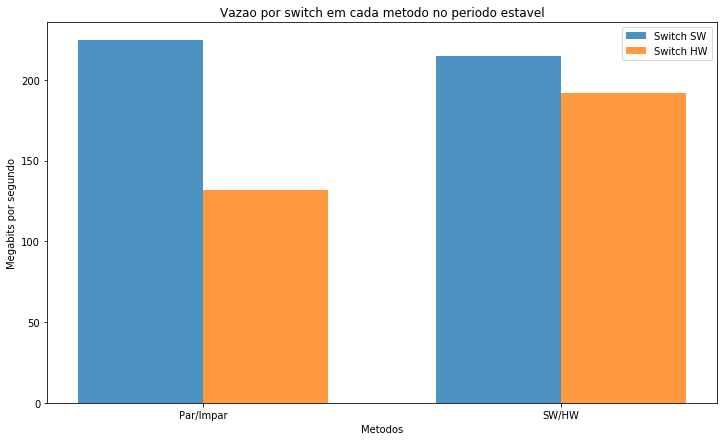

In [4]:
dfParImpar = pd.read_csv("../Saidas/Teste"+numParImpar+"/teste"+numParImpar+".csv")
dfSWHW = pd.read_csv("../Saidas/Teste"+numSW+"/teste"+numSW+".csv")
#Remove colunas desnecessarias
del dfParImpar['Timestamp']
del dfParImpar['?']
del dfParImpar['Tempo']
del dfSWHW['Timestamp']
del dfSWHW['?']
del dfSWHW['Tempo']

#Dividindo por metodo
dfServerParImpar = dfParImpar[dfParImpar.IpOri == '10.1.0.1']
dfServerSWHW = dfSWHW[dfSWHW.IpOri == '10.1.0.1']

#Pegando trafego no periodo estavel (150-250 segundos)
dfInfo = pd.read_csv("../Saidas/Teste"+numSW+"/iperfs.txt", sep="\t") #Pode ler de qualquer teste, sao iguais
portasEstaveisPar = []
portasEstaveisImpar = []
for index, row in dfInfo.iterrows():
    if (row['Inicio(seg)'] >= 150 and row['Inicio(seg)'] <= 250):
        if(row['PCli'] %2 == 0):
            portasEstaveisPar.append(int(row['PCli']))
        else:
            portasEstaveisImpar.append(int(row['PCli']))
        
#Dividindo por switch em cada metodo
hwParImpar = dfParImpar[dfParImpar.PortaOri %2 == 0]
hwParImpar = hwParImpar[hwParImpar['PortaDest'].isin(portasEstaveisPar)]
swParImpar = dfParImpar[dfParImpar.PortaOri %2 != 0]
swParImpar = swParImpar[swParImpar['PortaDest'].isin(portasEstaveisImpar)]
hwSWHW = dfSWHW[dfSWHW.PortaOri %2 == 0]
hwSWHW = hwSWHW[hwSWHW['PortaDest'].isin(portasEstaveisPar)]
swSWHW = dfSWHW[dfSWHW.PortaOri %2 != 0]
swSWHW = swSWHW[swSWHW['PortaDest'].isin(portasEstaveisImpar)]

listaSW = [swParImpar['BytesEnv'].sum()*8/1e8, swSWHW['BytesEnv'].sum()*8/1e8]
listaHW = [hwParImpar['BytesEnv'].sum()*8/1e8, hwSWHW['BytesEnv'].sum()*8/1e8]

n_groups = 2
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, listaSW, bar_width, alpha=opacity, label='Switch SW')
rects2 = plt.bar(index + bar_width, listaHW, bar_width, alpha=opacity, label='Switch HW')

plt.xlabel('Metodos')
plt.ylabel('Megabits por segundo')
plt.title('Vazao por switch em cada metodo no periodo estavel')
plt.xticks(index + bar_width/2, ('Par/Impar', 'SW/HW'))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12, 7)
#plt.tight_layout()
plt.savefig('vazaoPorSwitch_testes'+numParImpar+'e'+numSW+'.pdf')
plt.show()

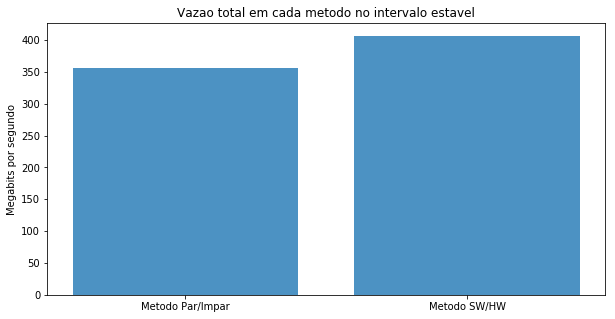

In [5]:
dfParImpar = pd.read_csv("../Saidas/Teste"+numParImpar+"/teste"+numParImpar+".csv")
dfSWHW = pd.read_csv("../Saidas/Teste"+numSW+"/teste"+numSW+".csv")
#Remove colunas desnecessarias
del dfParImpar['Timestamp']
del dfParImpar['?']
del dfParImpar['Tempo']
del dfSWHW['Timestamp']
del dfSWHW['?']
del dfSWHW['Tempo']

#Dividindo por metodo
portasEstaveis = portasEstaveisImpar + portasEstaveisPar
dfServerParImpar = dfParImpar[dfParImpar.IpOri == '10.1.0.1']
dfServerSWHW = dfSWHW[dfSWHW.IpOri == '10.1.0.1']
dfServerParImpar = dfServerParImpar[dfServerParImpar['PortaDest'].isin(portasEstaveis)]
dfServerSWHW = dfServerSWHW[dfServerSWHW['PortaDest'].isin(portasEstaveis)]

colunas = ('Metodo Par/Impar', 'Metodo SW/HW')
posicao = np.arange(len(colunas))
barras = [dfServerParImpar['BytesEnv'].sum()*8/1e8, dfServerSWHW['BytesEnv'].sum()*8/1e8]

plt.bar(posicao, barras, align='center', alpha=0.8)
plt.xticks(posicao, colunas)
plt.ylabel('Megabits por segundo')
plt.title('Vazao total em cada metodo no intervalo estavel')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.savefig('vazaoTotal_testes'+numParImpar+'e'+numSW+'.pdf')
plt.show()

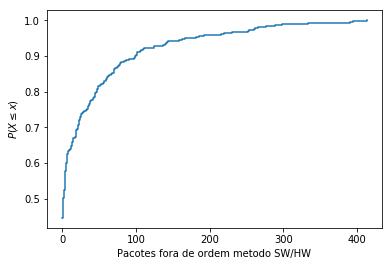

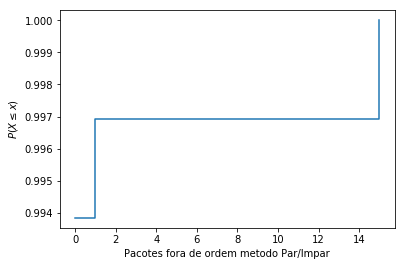

In [6]:
a = dfServerSWHW['ForaOrdem'].tolist()
b = dfServerParImpar['ForaOrdem'].tolist()

#CDF dos pacotes fora de ordem
x = np.sort(a)
x1 = np.sort(b)

ecdf = sm.distributions.ECDF(a)
ecdf1 = sm.distributions.ECDF(b)

y = ecdf(x)
y1 = ecdf1(x1)

#HW
plt.step(x, y, where='post')
plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Pacotes fora de ordem metodo SW/HW')
plt.savefig('foraOrdem_teste'+numSW+'.pdf')
plt.show()

#Par impar
plt.step(x1, y1, where='post')
plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Pacotes fora de ordem metodo Par/Impar')
plt.savefig('foraOrdem_teste'+numParImpar+'.pdf')
plt.show()

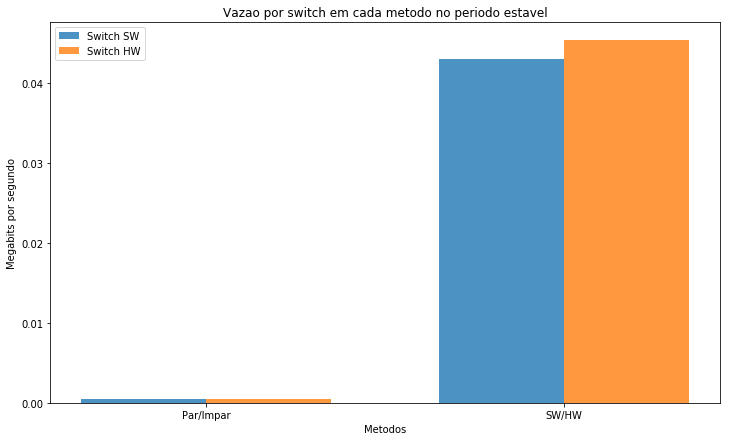

In [7]:
dfParImpar = pd.read_csv("../Saidas/Teste"+numParImpar+"/teste"+numParImpar+".csv")
dfSWHW = pd.read_csv("../Saidas/Teste"+numSW+"/teste"+numSW+".csv")
#Remove colunas desnecessarias
del dfParImpar['Timestamp']
del dfParImpar['?']
del dfParImpar['Tempo']
del dfSWHW['Timestamp']
del dfSWHW['?']
del dfSWHW['Tempo']

#Dividindo por metodo
dfServerParImpar = dfParImpar[dfParImpar.IpOri == '10.1.0.1']
dfServerSWHW = dfSWHW[dfSWHW.IpOri == '10.1.0.1']

#Pegando trafego no periodo estavel (150-250 segundos)
dfInfo = pd.read_csv("../Saidas/Teste"+numSW+"/iperfs.txt", sep="\t") #Pode ler de qualquer teste, sao iguais
portasEstaveisPar = []
portasEstaveisImpar = []
for index, row in dfInfo.iterrows():
    if (row['Inicio(seg)'] >= 150 and row['Inicio(seg)'] <= 250):
        if(row['PCli'] %2 == 0):
            portasEstaveisPar.append(int(row['PCli']))
        else:
            portasEstaveisImpar.append(int(row['PCli']))
        
#Dividindo por switch em cada metodo
hwParImpar = dfParImpar[dfParImpar.PortaOri %2 == 0]
hwParImpar = hwParImpar[hwParImpar['PortaDest'].isin(portasEstaveisPar)]
swParImpar = dfParImpar[dfParImpar.PortaOri %2 != 0]
swParImpar = swParImpar[swParImpar['PortaDest'].isin(portasEstaveisImpar)]
hwSWHW = dfSWHW[dfSWHW.PortaOri %2 == 0]
hwSWHW = hwSWHW[hwSWHW['PortaDest'].isin(portasEstaveisPar)]
swSWHW = dfSWHW[dfSWHW.PortaOri %2 != 0]
swSWHW = swSWHW[swSWHW['PortaDest'].isin(portasEstaveisImpar)]


listaSW = [swParImpar['PctPerdido'].sum()/swParImpar['PctEnv'].sum(), swSWHW['PctPerdido'].sum()/swSWHW['PctEnv'].sum()]
listaHW = [hwParImpar['PctPerdido'].sum()/hwParImpar['PctEnv'].sum(), hwSWHW['PctPerdido'].sum()/hwSWHW['PctEnv'].sum()]

n_groups = 2
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, listaSW, bar_width, alpha=opacity, label='Switch SW')
rects2 = plt.bar(index + bar_width, listaHW, bar_width, alpha=opacity, label='Switch HW')

plt.xlabel('Metodos')
plt.ylabel('Megabits por segundo')
plt.title('Vazao por switch em cada metodo no periodo estavel')
plt.xticks(index + bar_width/2, ('Par/Impar', 'SW/HW'))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12, 7)
#plt.tight_layout()
#plt.savefig('vazaoPorSwitch_testes'+numParImpar+'e'+numSW+'.pdf')
plt.show()


'''
Para pegar as perdas dos trafegos que nao aparecem no servidor e devem ser contadas no metodo par impar (pq nao terminaram):
1- Olhar os reports dos clientes, pegando apenas quem não tem report do servidor correspondente (nao terminou)
2- Pegar os reports no periodo estavel
3- Pegar a coluna BytesEnv do cliente, dividir por 1469 (tamanho medio de cada pacote)
4- Jogar o resultado (ou 80-90% dele) como pacote perdido (ja que nao terminou, perdeu tudo)
5- Fazer o grafico
'''